# Libraries


In [ ]:
import numbers
from numpy.lib.stride_tricks import as_strided
import numpy as np
from skimage import io, util
import sklearn.feature_extraction as sk
# from ksvd import ApproximateKSVD
import cv2
from itertools import product
import matplotlib.pyplot as plt
from scipy import linalg
from math import sqrt
import scipy
import math
import pywt

# KSVD CLASS 

## Ksvd class for training the dictionary.

In [ ]:
# coding:utf-8
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.linear_model import orthogonal_mp_gram


class ApproximateKSVD(object):
    def __init__(self, n_components, dictionary = None, max_iter=20, tol=1e-6,
                 transform_n_nonzero_coefs = None, l=0.1, n = 1):
        """
        Parameters
        ----------
        n_components:
            Number of dictionary elements

        max_iter:
            Maximum number of iterations

        tol:
            tolerance for error

        transform_n_nonzero_coefs:
            Number of nonzero coefficients to target
        """
        self.components_ = None
        self.max_iter = max_iter
        self.tol = tol
        self.n_components = n_components
        self.transform_n_nonzero_coefs = transform_n_nonzero_coefs
        self.l = l
        self.n = n
        self.D = dictionary

    def _update_dict(self, X, D, gamma):
        for j in range(self.n_components):
            I = gamma[:, j] > 0
            if np.sum(I) == 0:
                continue

            D[j, :] = 0
            g = gamma[I, j].T
#             print(gamma.shape)
#             print(X.shape)
#             print(len(I))
            r = X[I, :] - gamma[I, :].dot(D)
            d = r.T.dot(g)
            d /= np.linalg.norm(d)
            g = r.dot(d)
            D[j, :] = d
            gamma[I, j] = g.T
        return D, gamma

#     def _initialize(self, X): (Uncomment this for initializing the dictionary)
#         if min(X.shape) < self.n_components:
#             D = np.random.randn(self.n_components, X.shape[1])
# #             print("Dictionary:", D.shape)
#         else:
#             u, s, vt = sp.sparse.linalg.svds(X, k=self.n_components)
#             D = np.dot(np.diag(s), vt)
#         D /= np.linalg.norm(D, axis=1)[:, np.newaxis]
#         return D
    
    def fista(self, I, Phi, lambdav, n, max_iterations= 150):
        
#         def proxOp(x,t):
#             """ L1 Proximal Operator """ 
#             return np.fmax(x-t, 0) + np.fmin(x+t, 0)
        
        I = I.T
        Phi = Phi.T
        print("Phi shape", Phi.shape)
        print("l value", lambdav)
        print("n value", n)
        x = np.zeros((Phi.shape[1], I.shape[1]))
        Q = Phi.T.dot(Phi)
        c = -2*Phi.T.dot(I)
        print(max_iterations)

        L = scipy.sparse.linalg.eigsh(2*Q, 1, which='LM')[0]
        invL = 1/float(L)
        it = 0
        y = x
        t = 1
        gamma_list = []
        err = []

        for i in range(max_iterations):
            g = 2*Q.dot(y) + c
            x_prox = y - (invL * g)
            t_prox = invL*lambdav
            x2 = pywt.threshold_firm(x_prox, invL*lambdav, (invL*lambdav)*n)
            t2 = (1+math.sqrt(1+4*(t**2)))/2.0
            y = x2 + ((t-1)/t2)*(x2-x)
            x = x2
            t = t2
#             ee = np.linalg.norm(I.T - x2.T.dot(Phi.T))
#             err.append(ee)
        
            if(i == 25 or i == 50 or i == 100):
              gamma_list.append(x2)
              

        it += 1
#         plt.plot(err)
#         plt.show()

        print("Iteration {0} done.".format(it))
        
        for j in range(3):
          gamma_list[j] = gamma_list[j].T

        return x2, gamma_list

    def fit(self, X, l = 0.1, n = 1):
        """
        Parameters
        ----------
        X: shape = [n_samples, n_features]
        """
        # print(X)
        # print(X.shape[1])
        y = []
        gamma_list = []
        D = self.D
        l = self.l
        n = self.n
        transform_n_nonzero_coefs = self.transform_n_nonzero_coefs
        for i in range(self.max_iter):
            dict_list = []
            gamma, gamma_list = self.fista(X, D, l, n, max_iterations = 150)
            gamma = gamma.T
            
            e = np.linalg.norm(X - gamma.dot(D))
            y.append(e)
            print("||Y - DX||2 for iteration {0} is: ".format(i+1), e)
            if e < self.tol:
                break
            
            print("gamma shape", gamma.shape)
            print("gama list shape", gamma_list[0].shape)
            print("D shape", D.shape)
            
            
            D, gamma = self._update_dict(X, D, gamma)


        plt.plot(y)
        plt.show()


        return D

    def transform(self, X, dictionary, l = 0.1, n = 1):
        gamma_list = []
        gamma, gamma_list = self.fista(X, dictionary, l,  n, max_iterations = 150)
        return gamma, gamma_list


# Function to compute the number of patches

In [ ]:
def _compute_n_patches(i_h, i_w, p_h, p_w, step, max_patches=None):

    n_h = (i_h - p_h) // step + 1
    n_w = (i_w - p_w) // step + 1
    all_patches = n_h * n_w

    return all_patches

# Function to extract the patches from Input Image

In [ ]:
def _extracting(arr, patch_shape=8, extraction_step=1):

    arr_ndim = arr.ndim

    if isinstance(patch_shape, numbers.Number):
        patch_shape = tuple([patch_shape] * arr_ndim)
    if isinstance(extraction_step, numbers.Number):
        extraction_step = tuple([extraction_step] * arr_ndim)

    patch_strides = arr.strides

    slices = tuple(slice(None, None, st) for st in extraction_step)
    indexing_strides = arr[slices].strides

    patch_indices_shape = ((np.array(arr.shape) - np.array(patch_shape)) //
                           np.array(extraction_step)) + 1

    shape = tuple(list(patch_indices_shape) + list(patch_shape))
    strides = tuple(list(indexing_strides) + list(patch_strides))

    patches = as_strided(arr, shape=shape, strides=strides)

    # patches = patches.reshape([-1] + list(patch_shape))

    return patches

# Function to call the extraction step and reshaping the patches

In [ ]:
def extract_patches(image, patch_size, step, max_patches=None, random_state=None):

    i_h, i_w = image.shape[:2]
    p_h, p_w = patch_size

    # image = check_array(image, allow_nd=True)
    image = image.reshape((i_h, i_w, -1))
    n_colors = image.shape[-1]

    extracted_patches = _extracting(image, patch_shape=(p_h, p_w, n_colors), extraction_step=step) # above function call
    n_patches = _compute_n_patches(i_h, i_w, p_h, p_w, step, max_patches)
    # print n_patches
    # if max_patches:
    #     rng = check_random_state(random_state)
    #     i_s = rng.randint(i_h - p_h + step, size=n_patches)
    #     j_s = rng.randint(i_w - p_w + step, size=n_patches)
    #     patches = extracted_patches[i_s, j_s, 0]
    # else:
    patches = extracted_patches

    patches = patches.reshape(-1, p_h, p_w, n_colors)
    # print patches.shape
    # remove the color dimension if useless
    if patches.shape[-1] == 1:
        return patches.reshape(n_patches, p_h, p_w)
    else:
        return patches


# Funtion for Reconstruction of the image from the patches

In [ ]:
def reconstruct_patches(patches, image_size, step):

    i_h, i_w = image_size[:2]
    p_h, p_w = patches.shape[1:3]
    img = np.zeros(image_size)
    # compute the dimensions of the patches array
    n_h = int((i_h - p_h) / step + 1)
    n_w = int((i_w - p_w) / step + 1)
    for p, (i, j) in zip(patches, product(range(n_h), range(n_w))):
        img[i * step:i * step + p_h, j * step:j * step + p_w] += p

    for i in range(i_h):
        for j in range(i_w):
            img[i, j] /= float(min(i + step, p_h, i_h - i) *
                               min(j + step, p_w, i_w - j))
    return img


# If the input image is not noisy, function to add noise.

In [ ]:
img = util.img_as_float(io.imread("C:/Users/DELL/PycharmProjects/ksvd_final/input/Lenna.jpg"))
print("Adding Noise")
img_with_noise = util.random_noise(img, seed=1)
io.imsave("noise.png", img_with_noise)
print("Done with noise")

Adding Noise
Done with noise


# Loading of Image and Extracting patches

In [7]:
img = util.img_as_float(cv2.imread("girl_face_noise_5.jpg", 0))
# image = io.imread("C:/Users/DELL/PycharmProjects/ksvd_final/Prova.jpg")

res = extract_patches(img, (8, 8), 1)
# width, height, col= res.shape
# print("initial Image shape", img.shape)
print("Patches shape: ", res.shape)
num_patch, p_h, p_w = res.shape

Patches shape:  (36540, 8, 8)


# Functions for converting 2d or 3d matrix to vector and vice versa

In [ ]:
def matrix_to_vector(matrix, patch_size):
    
    list = np.split(matrix.reshape(-1,patch_size),matrix.shape[0])
    
    list1 = []
    
    
    for arr in list:
        bb = arr.flatten('F').reshape(patch_size**2,1)
        list1.append(bb)

    array = np.array(list1).squeeze()
    
    return array


def vector_to_matrix_2d(vector,h,w):
    
    ab = np.reshape(vector,(h,w))
    return ab.T

def vector_to_matrix_3d(vector, h, w, col):

    ab = np.reshape(vector,(h,w,col))
#     print(ab.T)
    return ab.transpose(0,2,1)


# aa= np.array(range(27)).reshape(3,3,3)
# print(aa)
# print("------------------------")

# bb = matrix_to_vector(aa, 3)
# print(bb)

# ab = vector_to_matrix_3d(array, -1,3,3)
# print(ab)

# ba = vector_to_matrix_2d(bb[0], 3, 3)
# print(ba)




# Pre-Processing step: Removing the mean from each value of the patches

In [ ]:
imag = res[1]
print(imag.shape)
io.imshow(imag, cmap= 'gray')
io.show()

signals = matrix_to_vector(res, p_w)

num_patches, patch_size = signals.shape

print("Signals final shape", signals.shape)
mean = np.mean(signals, axis=0)[:, np.newaxis]
print("Mean value shape: ", mean.shape)

mean1 = vector_to_matrix_2d(mean,p_h,p_w)
io.imshow(mean1, cmap = 'gray')
io.show()

signals = (signals.T - mean).T

signals1 = vector_to_matrix_2d(signals[1], p_h, p_w)
io.imshow(signals1, cmap = 'gray')
io.show()

signal_final = signals1 + mean1

io.imshow(signal_final,  cmap= 'gray')
io.show()

if signal_final.all() == imag.all():
    print("True")
else:
    print("false")

# Applying KSVD 

In [ ]:
print("Applying L1-DL")
aksvd = ApproximateKSVD(n_components=128, l = 0.2)
dictionary = aksvd.fit(signals).components_
print("Done with learning")
# np.savetxt("test.txt", dictionary)
gamma = aksvd.transform(signals, l = 0.2)
print("Found gamma")

# Applying KSVD with Dictionary Initialization (Comment the above cell and choose this)

In [ ]:
import scipy.io as sio

dict_list = []
gamma_list = []

bdict = sio.loadmat('dictionary_intialize.mat')
for rel in bdict:
   if rel == 'dictionary':
      diction = bdict['dictionary']

print(diction.shape)

print("Applying L1-DL")
aksvd = ApproximateKSVD(n_components=128, dictionary = diction, l = 0.1, n = 60)
dictionary = aksvd.fit(signals)
print("Done with learning")
# np.savetxt("test.txt", dictionary)
gamma, gamma_list = aksvd.transform(signals, dictionary, l = 0.1, n = 60)
print("Found gamma")

In [113]:
from numpy import array
from numpy import count_nonzero
import numpy as np


sparsity = 1.0 - ( count_nonzero(gamma) / float(gamma.size) )
print(sparsity*100)

85.40941861658456


In [114]:
import scipy.io as sio

dict_list = []

dict_25, gamma_25 = aksvd._update_dict(signals, dictionary, gamma_list[0])
dict_50, gamma_50 = aksvd._update_dict(signals, dictionary, gamma_list[1])
dict_100, gamma_100 = aksvd._update_dict(signals, dictionary, gamma_list[2])

dict_list = [dict_25, dict_50, dict_100]
print(len(dict_list))

adict = {}
adict['dictionary_25'] = dict_list[0]
adict['dictionary_50'] = dict_list[1]
adict['dictionary_100'] = dict_list[2]

sio.savemat('diff_dict.mat', adict)

for rel in adict:
  print(rel)

3
dictionary_25
dictionary_50
dictionary_100


In [ ]:
# import scipy.io as sio

# adict = {}
# adict['dictionary_25'] = dict_list[0]
# adict['dictionary_50'] = dict_list[1]
# adict['dictionary_100'] = dict_list[2]

# sio.savemat('diff_dict.mat', adict)

# for rel in adict:
#   print(rel)

In [115]:
import scipy.io as sio

agamma = {}
agamma['gamma_25'] = gamma_list[0]
agamma['gamma_50'] = gamma_list[1]
agamma['gamma_100'] = gamma_list[2]

sio.savemat('diff_gamma.mat', agamma)

print(gamma_list[0].shape)

for rel in agamma:
  print(rel)


(36540, 128)
gamma_25
gamma_50
gamma_100


In [116]:
import scipy.io as sio

adict = {}
adict['dictionary'] = dictionary

sio.savemat('sigma_20_lambda_0.3_150_iterations_n = 100_patch_size_{0}x{1}.mat'.format(p_h,p_w), adict)

bdict = sio.loadmat('sigma_20_lambda_0.3_150_iterations_n = 100_patch_size_{0}x{1}.mat'.format(p_h,p_w))
for rel in bdict:
    print(rel)

__header__
__version__
__globals__
dictionary


(64,)
(1, 64)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


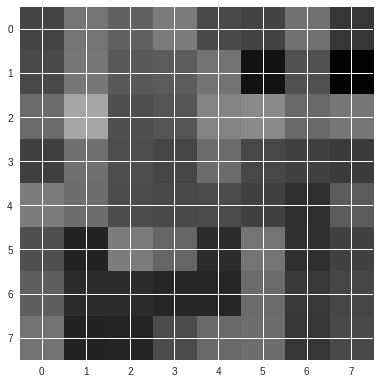

In [ ]:
print(dictionary[1].shape)
element = dictionary[1] + mean.T
print(element.shape)
element_1 = vector_to_matrix_2d(element, p_h, p_w)
io.imshow(element_1, cmap = 'gray')
io.show()

# Function for extracting images (patches) from Folder

In [ ]:
from tempfile import TemporaryFile
import numpy as np
import cv2
import os
from skimage import io
from PIL import Image


def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = os.path.join(folder, filename)
        if img is not None:
            images.append(img)
    return images

# Function to load the dictionary and convert to patches

In [ ]:
dictionary1 = dictionary.T + mean

file = dictionary1
print(file.shape)

K = file.shape[1]
# file1 = file.T
# print(file1.shape)

i = 0
k = 0
a = np.zeros((8, 16))
b = np.zeros((8, 8))
result = []
#
while k < file.shape[1]:
    arr = file[:,k]
    # a, b = split_array(arr)
    a = np.reshape(arr, (-1, 8))
    # b = np.reshape(b, (-1, 8))

    result.append(a)

    k += 1


(64, 128)


# Save each extracted patch as an image

In [ ]:
count = 0

for i in range(result.__len__()):
    path = 'jup_images'
    io.imsave(os.path.join(path, 'img_{0}.jpg').format(i), result[i])
    count += 1

print(count)

c:\users\dell\pycharmprojects\ksvd_final\venv\lib\site-packages\skimage\io\_io.py:140: UserWarning: jup_images\img_0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
c:\users\dell\pycharmprojects\ksvd_final\venv\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
c:\users\dell\pycharmprojects\ksvd_final\venv\lib\site-packages\skimage\io\_io.py:140: UserWarning: jup_images\img_1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


200


# Load the images and concatenate them to save as a single image

In [ ]:
image = io.imread("C:/Users/DELL/PycharmProjects/ksvd_final/jup_images/img_0.jpg")

images = load_images_from_folder("C:/Users/DELL/PycharmProjects/ksvd_final/jup_images/")

BLUE = [0, 0, 0]
final = []

for img in images:
    img = cv2.imread(img)
    de_img= cv2.copyMakeBorder(img,1,1,1,1,cv2.BORDER_CONSTANT,value= BLUE)
    final.append(de_img)
    
count = 0

for i in range(final.__len__()):
    path = 'jup_images_final'
    io.imsave(os.path.join(path, 'img_{0}.jpg').format(i), final[i])
    count += 1

print(count)

final_images = load_images_from_folder("C:/Users/DELL/PycharmProjects/ksvd_final/jup_images_final/")

new_im = Image.new('RGB', (80, 160))

x_offset = 0
y_offset = 0
count = 0

i = 0
k = 0
j = 0

# for img in images:
#     imga = io.imread(img)
#     count += 1
#     print(count)
#     io.imshow(imga)
#     io.show()


while j < 16:
    while i < 8:
        # fin = open(image)  # open the file
        img = Image.open(final_images[k])
        ext_img = img
        new_im.paste(ext_img, (x_offset, y_offset))
        x_offset += img.size[0]
        i += 1
        print('yes x_{0}'.format(i))
        print('yes k_{0}'.format(k))
        print("Offset x: ", x_offset)
        k += 1
    i = 0
    y_offset += img.size[1]
    x_offset = 0
    j += 1
    print('yes y_{0}'.format(j))
    print("Y-offset", y_offset)

print("X:", x_offset)
print("Y:", y_offset)

new_im.save('test2.jpg')

imagee = io.imread("test2.jpg")
io.imshow(imagee)
io.show()

# Reconstruction of the Image

reconstruction patches shape: (36540, 64)
Final patch shape (36540, 8, 8)
recon image shape: (217, 181)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


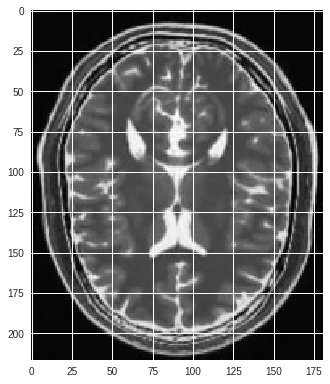

[[7 6 5 ... 6 7 8]
 [7 6 6 ... 6 7 8]
 [7 7 6 ... 6 6 7]
 ...
 [6 6 6 ... 6 6 7]
 [7 6 6 ... 6 6 7]
 [7 6 5 ... 6 7 7]]
Done....


In [117]:
def convert_to_uint8(image_in):
    temp_image = np.float64(np.copy(image_in))
    cv2.normalize(temp_image, temp_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    return temp_image.astype(np.uint8)

reduced = (gamma.T.dot(dictionary)) + mean.T

for ele in reduced:
    if ele.any() < 0:
        print("yes")
print("reconstruction patches shape:", reduced.shape)
red = reduced.reshape(res.shape)
print('Final patch shape', red.shape)
final_patches = vector_to_matrix_3d(reduced, -1,p_h,p_w)
reduced_img = reconstruct_patches(final_patches, img.shape, 1)
print("recon image shape:", reduced_img.shape)
# print(reduced)
fin_recon_image = convert_to_uint8(reduced_img)
cv2.imwrite('0.3_150_n = 100_sigma_20_l1.jpg', fin_recon_image)
io.imshow(fin_recon_image, cmap = 'gray')
io.show()
print(fin_recon_image)
print("Done....")

reconstruction patches shape: (36540, 64)
Final patch shape (36540, 8, 8)
recon image shape: (217, 181)
[[11 10 10 ...  8  9 10]
 [ 9 10 10 ...  8  9  9]
 [ 8 10 10 ...  8  8  8]
 ...
 [10  9  9 ...  9  9  9]
 [12 10  9 ... 10  9  9]
 [12 10  8 ... 10 10  9]]


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


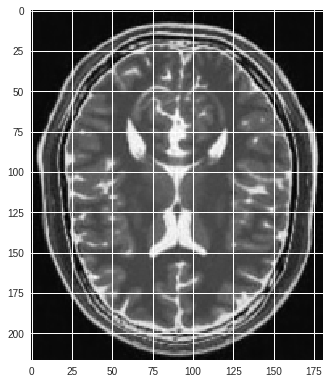

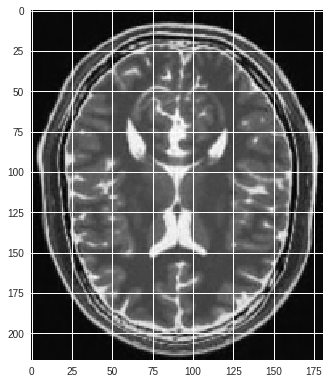

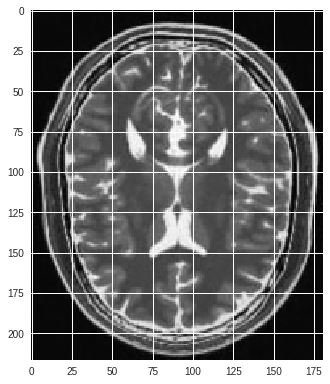

Done....


In [118]:
def convert_to_uint8(image_in):
    temp_image = np.float64(np.copy(image_in))
    cv2.normalize(temp_image, temp_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    return temp_image.astype(np.uint8)

reduced_25 = (gamma_list[0].dot(dict_list[0])) + mean.T
reduced_50 = (gamma_list[1].dot(dict_list[1])) + mean.T
reduced_100 = (gamma_list[2].dot(dict_list[2])) + mean.T


for ele in reduced:
    if ele.any() < 0:
        print("yes")
print("reconstruction patches shape:", reduced.shape)

red_25 = reduced_25.reshape(res.shape)
red_50 = reduced_50.reshape(res.shape)
red_100 = reduced_100.reshape(res.shape)

print('Final patch shape', red_25.shape)

final_patches_25 = vector_to_matrix_3d(reduced_25, -1,p_h,p_w)
final_patches_50 = vector_to_matrix_3d(reduced_50, -1,p_h,p_w)
final_patches_100 = vector_to_matrix_3d(reduced_100, -1,p_h,p_w)

reduced_img_25 = reconstruct_patches(final_patches_25, img.shape, 1)
reduced_img_50 = reconstruct_patches(final_patches_50, img.shape, 1)
reduced_img_100 = reconstruct_patches(final_patches_100, img.shape, 1)

print("recon image shape:", reduced_img_25.shape)
# print(reduced)
fin_recon_image_25 = convert_to_uint8(reduced_img_25)
fin_recon_image_50 = convert_to_uint8(reduced_img_50)
fin_recon_image_100 = convert_to_uint8(reduced_img_100)

print(fin_recon_image_25)
# io.imsave("25 iterations", fin_recon_image_25)

cv2.imwrite('25 iterations.jpg', fin_recon_image_25)
cv2.imwrite('50 iterations.jpg', fin_recon_image_50)
cv2.imwrite('100 iterations.jpg', fin_recon_image_100)

io.imshow(fin_recon_image_25, cmap = 'gray')
io.show()
io.imshow(fin_recon_image_50, cmap = 'gray')
io.show()
io.imshow(fin_recon_image_100, cmap = 'gray')
io.show()
# print(fin_recon_image)
print("Done....")

# If stride > 1, image contrast reduces, to improve the contrast apply Histogram matching with noisy image. 

## Function to implement the histogram matching

In [ ]:
import numpy as np
import cv2

def hist_match(source, template):
    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)




## Reading both the images and calling the matching function

In [ ]:
from matplotlib import pyplot as plt
from scipy.misc import ascent
import imageio as ios

# Image Input
image = cv2.imread("reduced_final_0.2_l1.jpg", 0)

image1 = cv2.imread("girl_face_noise_15.jpg", 0)

x, y= image.shape

x1, y1 = image1.shape


moddedimage = np.zeros([x, y], dtype=np.uint8)

# gray levels
gray_levels = 256
# row times column
mn = x * y

source = image
template = image1
matched = hist_match(source, template)


def ecdf(x):
    vals, counts = np.unique(x, return_counts=True)
    ecdf = np.cumsum(counts).astype(np.float64)
    ecdf /= ecdf[-1]
    return vals, ecdf


x1, y1 = ecdf(source.ravel())
x2, y2 = ecdf(template.ravel())
x3, y3 = ecdf(matched.ravel())


plt.imshow(source, cmap='gray')
plt.axis('off')
plt.title('Source')
plt.show()
plt.imshow(template, cmap='gray')
plt.axis('off')
plt.title('Noisy Image')
plt.show()
plt.imshow(matched, cmap='gray')
plt.axis('off')
plt.title('Denoised Image')
plt.show()

cv2.imwrite("reduced_final_0.2_l1_hist.jpg",matched)

# image = cv2.imread("C:/Users/DELL/PycharmProjects/ksvd_final/matched.png", 0)
# cv2.imshow("image", image)
# cv2.waitKey(0)


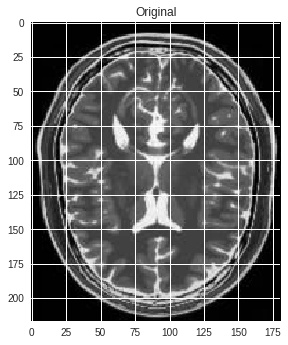

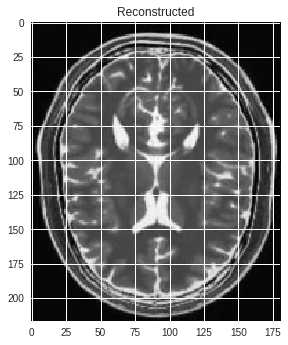

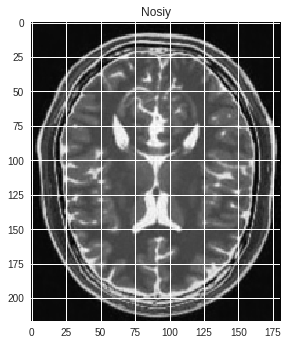

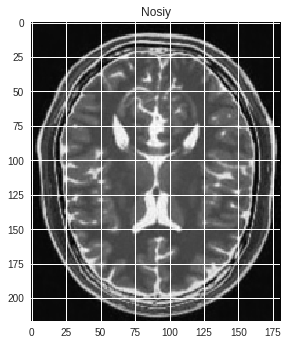

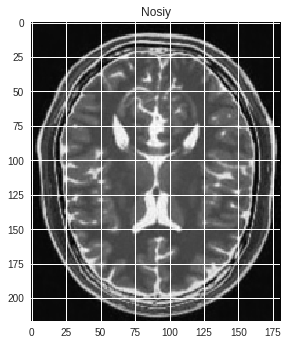

0
255
------------------
0
255
Mse: 45.51859867097792
PSNR between original and 25 iterations 31.548914774024574
Mse: 39.49705934770986
PSNR between original and 50 iterations 32.165155983200215
Mse: 36.83700384448914
PSNR between original and 100 iterations 32.46796061458226
Mse: 29.85108333121165
PSNR between original and 150 iterations: 33.381202640547855


In [119]:
import math

# print(matched.dtype)

# data = matched
# data = data/(data.max())
# data = 255 * data
# img = data.astype(np.uint8)

def convert_to_uint8(image_in):
    temp_image = np.float64(np.copy(image_in))
    cv2.normalize(temp_image, temp_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    return temp_image.astype(np.uint8)

# count =0
# for ele in matched:
#     if ele.any() < 0:
#         count += 1

# print(count)

original = cv2.imread("image.jpg",0)
# print(original.dtype)
plt.title("Original")
plt.imshow(original, cmap ='gray')
plt.show()

image = fin_recon_image
# contrast = convert_to_uint8(image)
# print(original.dtype)
plt.title("Reconstructed")
plt.imshow(image, cmap ='gray')
plt.show()


noisy = fin_recon_image_25
plt.imshow(noisy, cmap = 'gray')
plt.title("Nosiy")
plt.show()

noisy1 = fin_recon_image_50
plt.imshow(noisy, cmap = 'gray')
plt.title("Nosiy")
plt.show()

noisy2 = fin_recon_image_100
plt.imshow(noisy, cmap = 'gray')
plt.title("Nosiy")
plt.show()



# contrast = img
# plt.imshow(contrast, cmap = 'gray')
# plt.show()

i_h, i_w = original.shape
pixels = i_h * i_w

print(original.min())
print(original.max())
print("------------------")
print(image.min())
print(image.max())

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2 )
    print("Mse:", mse)
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    result_psnr = (20 * math.log10(PIXEL_MAX / math.sqrt(mse)))
    return result_psnr

  
d= psnr(original, noisy)
print("PSNR between original and 25 iterations", d)

d= psnr(original, noisy1)
print("PSNR between original and 50 iterations", d)

d= psnr(original, noisy2)
print("PSNR between original and 100 iterations", d)

d=psnr(original,image)
print("PSNR between original and 150 iterations:", d)

In [ ]:
# imagee = io.imread("F:/Internship/Data/brain_0% noise/brain_0_105.jpg")
# io.imshow(imagee)
# io.show()
# print(imagee.shape)

def convert_to_uint8(image_in):
    temp_image = np.float64(np.copy(image_in))
    cv2.normalize(temp_image, temp_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    return temp_image.astype(np.uint8)


image = cv2.imread('reduced_final_11_l1.jpg', 0)
print(image.shape)
io.imshow(image)
io.show()

contrast = convert_to_uint8(image)
# print(original.dtype)
plt.title("Reconstructed")
plt.imshow(contrast, cmap ='gray')
plt.show()
# image = cv2.imread('girl_face_noise_20.jpg', 0)
# print(image.shape)
# io.imshow(image)
# io.show()

In [120]:
from skimage.measure import compare_ssim as ssim

def mse(x, y):
    return np.linalg.norm(x - y)
  
image = cv2.imread("image.jpg", 0)
recon_image_25 = cv2.imread("25 iterations.jpg",0)
recon_image_50 = cv2.imread("50 iterations.jpg",0)
recon_image_100 = cv2.imread("100 iterations.jpg",0)
recon_image_150 = cv2.imread("0.3_150_n = 100_sigma_20_l1.jpg",0)


# print(recon_image.shape)
# print(image.shape)

mse_noise_25 = mse(image, recon_image_25)
ssim_noise_25 = ssim(image, recon_image_25,
                  data_range=recon_image_25.max() - recon_image_25.min())

mse_noise_50 = mse(image, recon_image_50)
ssim_noise_50 = ssim(image, recon_image_50,
                  data_range=recon_image_50.max() - recon_image_50.min())

mse_noise_100 = mse(image, recon_image_100)
ssim_noise_100 = ssim(image, recon_image_100,
                  data_range=recon_image_100.max() - recon_image_100.min())

mse_noise_150 = mse(image, recon_image_150)
ssim_noise_150 = ssim(image, recon_image_150,
                  data_range=recon_image_150.max() - recon_image_150.min())

print("25 iterations mse", mse_noise_25)
print('25 iterations ssim', ssim_noise_25)
 
print("50 iterations mse", mse_noise_50)
print('50 iterations ssim', ssim_noise_50)

print("100 iterations mse", mse_noise_100)
print('100 iterations ssim', ssim_noise_100)

print("150 iterations mse", mse_noise_150)
print('150 iterations ssim', ssim_noise_150)


25 iterations mse 45522.247242419835
25 iterations ssim 0.8625360288000133
50 iterations mse 44813.49978522097
50 iterations ssim 0.8664710552119539
100 iterations mse 44606.57161226359
100 iterations ssim 0.8699420960428014
150 iterations mse 43034.62515231194
150 iterations ssim 0.8847728315381767


In [ ]:
rimport cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('image.jpg',0)
plt.hist(img.ravel(),256,[0,256])
plt.show()

img = cv2.imread('girl_face_noise_15.jpg',0)
plt.hist(img.ravel(),256,[0,256])
plt.show()

In [ ]:
import numpy, scipy.io

arr = numpy.arange(9)
arr = arr.reshape((3, 3))  # 2d array of 3x3

scipy.io.savemat('arrdata.mat', mdict={'arr': arr})

In [ ]:
import scipy.io
mat = scipy.io.loadmat('test_struct_to_mat.mat')
print(mat)

df = pd.DataFrame(np.hstack((mat['X'], mat['y'])))
cardio_df.head()

In [ ]:
import pandas as pd

df = pd.read_excel('Results.xlsx')
print(df)

a_dict = {col_name : df[col_name].values for col_name in df.columns.values}
scipy.io.savemat('test_struct_to_mat.mat', {'struct':a_dict})

   Iterations  Lambda     PSNR     SSIM
0          25    0.05  34.3980  0.91774
1          50    0.01  33.7855  0.89810
2         100    0.10  33.9590  0.91090
3         150    0.05  34.4540  0.92120
